
# Using PoreSpy for Quantitative Image Analysis
---
Finally we are ready to start analyzing images. The ``porespy`` package has many functions that are custom built for the study of porous media images. This includes tools for calculating pore sizes, obtaining tortuosity, analyzing anisotropy and more.
 
PoreSpy is organized into the following modules:

- ``generators``: Functions for generating artificial images useful for testing and validation
- ``filters``: Functions for manipulating images to replace voxel values with some computed values
- ``metrics``: Functions for analyzing images to extract quantitative information
- ``simulations``: Functions for performing physical simulations directly on images
- ``networks``: Functions for extracting pore networks from images for use in OpenPNM
- ``visualization``: Functions for performing basic visualizations of 3D images
- ``io``: A small set of functions for converting between various formats
- ``tools``: Functions mostly used within PoreSpy itself

In [1]:
import porespy as ps
import matplotlib.pyplot as plt
import numpy as np
from edt import edt
import scipy.ndimage as spim

## Generating an Image for Demonstration
---
Let's start by generating an image of non-overlapping spheres using the 'random sequential addition' algorithm. 

> Note that all demonstrations will be done with 2D images to conserve CPU time and aid visualization

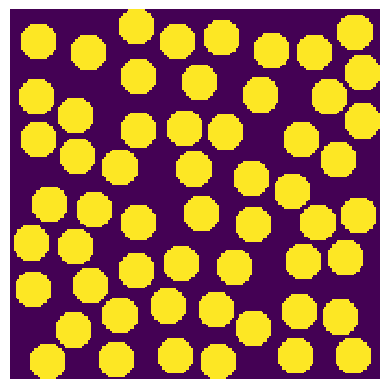

In [2]:
im = ps.generators.rsa([200, 200], r=10, clearance=1)
plt.imshow(im, interpolation='none', origin='lower')
plt.axis(False);

## Defining the Image "Foreground" 
---
The *foreground* or the *phase of interest* in PoreSpy is always the voxels marked ``True``.  

The ``rsa`` function has labelled the spheres as ``True``.  If we want the spheres to be solid grains then the we must invert the image.  

This is very simple:

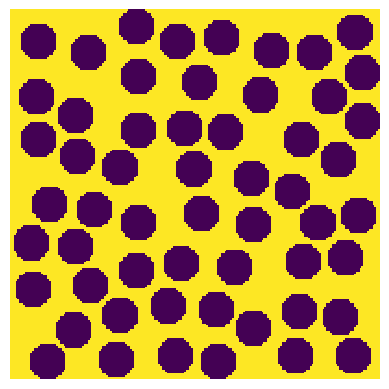

In [3]:
im = ~im
plt.imshow(im, interpolation='none', origin='lower')
plt.axis(False); 

## Porosity
---
The most basic property of an image, and a sample of porous media in general, is the porosity.  

This is defined as the ratio of void volume to bulk volume.  

In terms an image this means the number of "yellow" pixels" divided to the total number of pixels in the image:

In [4]:
porosity = np.sum(im)/np.size(im)
print(porosity)

0.573


## Pore Size Distributions
---
The spheres above all have a radius of 10 voxels, but the spaces between the spheres are distributed due to their random placement. 

One of the common ways to estimate pore sizes is using the "local thickness".  

PoreSpy has a ``local_thickness`` function, which draws the largest possible spheres in all the *foreground* pixels, and indicates the size of the spheres by the voxel value it inserts into the image: 

  0%|          | 0/25 [00:00<?, ?it/s]

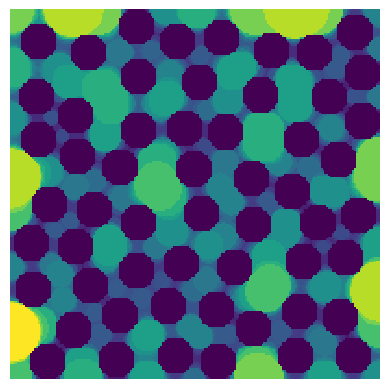

In [5]:
lt = ps.filters.local_thickness(im)
plt.imshow(lt, interpolation='none', origin='lower')
plt.axis(False);

We can get a quick look at the pore size distribution by creating a histogram of the voxel values:

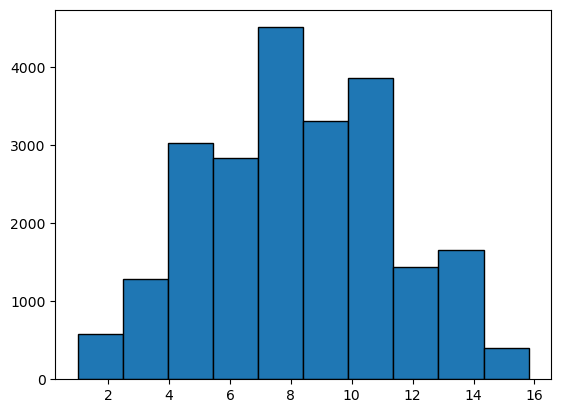

In [6]:
plt.hist(lt[lt > 0].flatten(), bins=10, edgecolor='k');

The previous curve showed that the average pore radius is around 8 voxels.  PoreSpy offers a more rigorous way to analyze this output via the ``metrics`` module.  In this case the results of the ``local_thickness`` filter are passed to the ``pore_size_distribution`` function:

In [7]:
psd = ps.metrics.pore_size_distribution(lt, bins=15, log=False)

The ``psd`` object that is returned has various data stored as "attributes".  This object can be ``printed`` to inspect these values:

In [8]:
print(psd)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Item                      Description
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
R                         Array of size (15,)
pdf                       Array of size (15,)
cdf                       Array of size (15,)
satn                      Array of size (15,)
bin_centers               Array of size (15,)
bin_edges                 Array of size (16,)
bin_widths                Array of size (15,)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Using these values we can plot the cumulative distribution as follows:

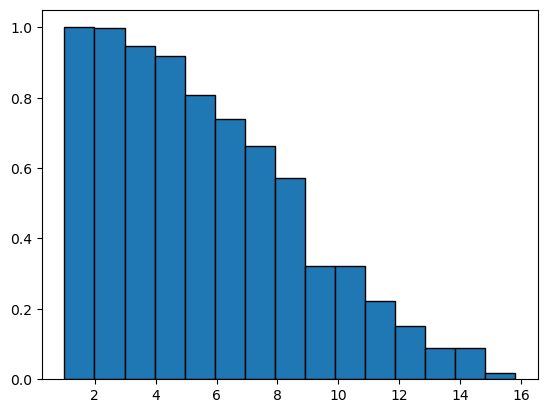

In [9]:
plt.bar(x=psd.R, height=psd.cdf, width=psd.bin_widths, edgecolor='k');

### Setting Voxel Size
---
The above analysis was conducted in units of voxels.  It is usually the case that physical sizes are desired, and moreover, all imaging techniques include the voxel size.  

The above few steps can be re-run but with the voxel size specified (assume 10 um/voxel):

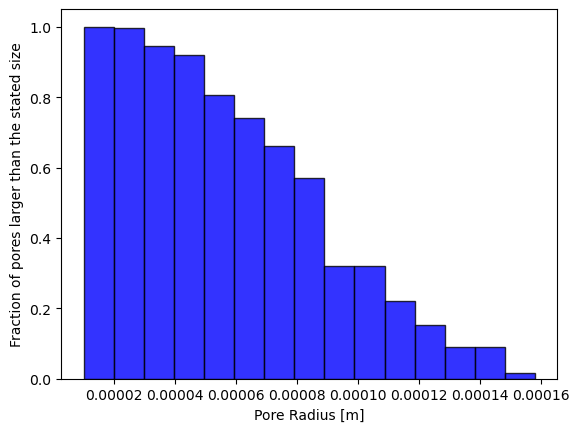

In [10]:
psd = ps.metrics.pore_size_distribution(lt, bins=15, log=False, voxel_size=1e-5)
plt.bar(x=psd.R, height=psd.cdf, width=psd.bin_widths, edgecolor='k', color='b', alpha=0.8)
plt.xlabel('Pore Radius [m]')
plt.ylabel('Fraction of pores larger than the stated size');

## Background on How Local Thickness is Computed
---
It is instructive to look at how the local thickness is calculated, since this involves some elementary image operations which are used widely, namely image dilation and erosion.  

### Step 1: Find all void voxels on which a sphere is size R can be drawn using a distance transform
---

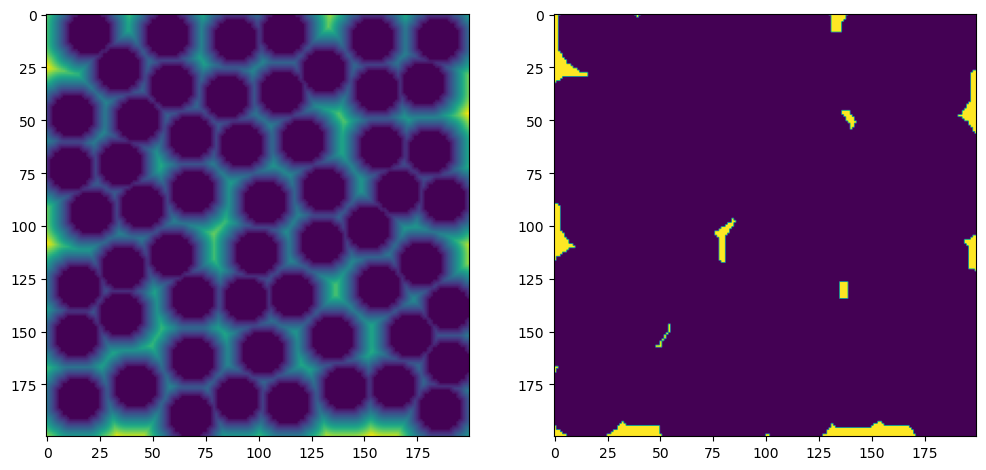

In [11]:
lt = np.zeros_like(im, dtype=int)
R = 10
dt = edt(im)
fig, ax = plt.subplots(1, 2, figsize=[12, 6])
ax[0].imshow(dt)
ax[1].imshow(dt >= R);

### Step 2: Dilate the surviving voxels by R
---

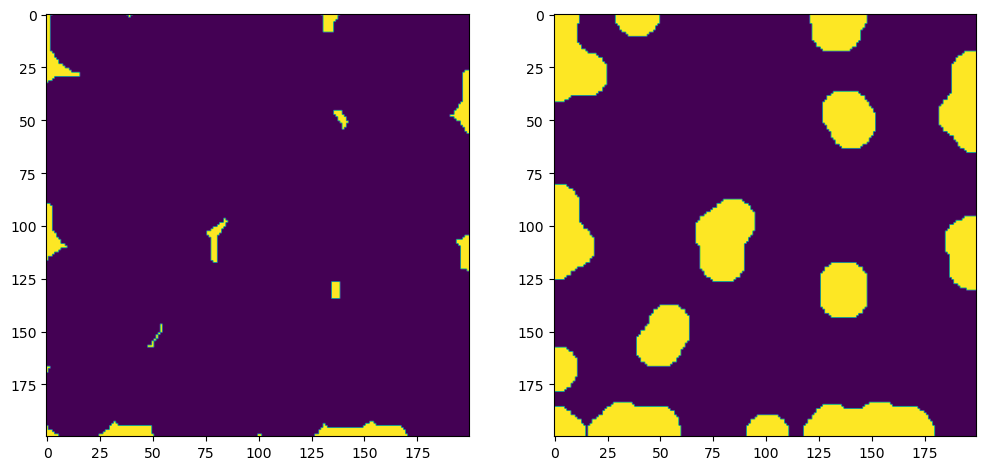

In [12]:
temp = spim.binary_dilation(dt >= R, structure=ps.tools.ps_round(r=R, ndim=2))
fig, ax = plt.subplots(1, 2, figsize=[12, 6])
ax[0].imshow(dt >= R)
ax[1].imshow(temp);

### Step 3: Mark these locations with the radius, unless they already have a larger value
---

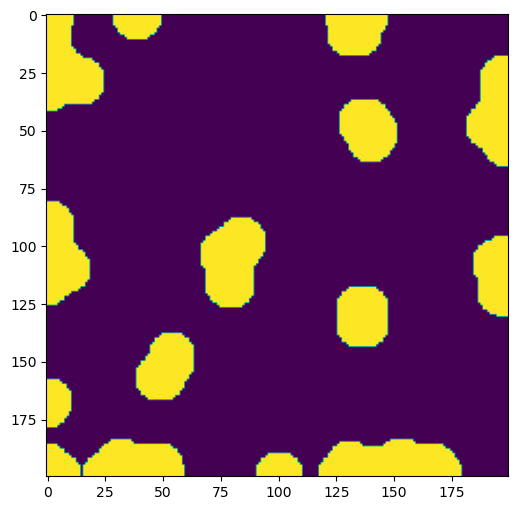

In [13]:
lt = lt + R*temp*(lt == 0)
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.imshow(lt);

### Step 4: Repeat with R=9
---
Now repeat steps 1 to 3 with a smaller value of R:

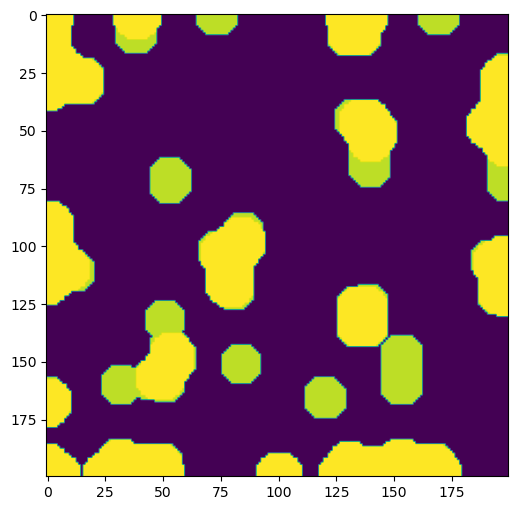

In [14]:
R = 9
temp = spim.binary_dilation(dt >= R, structure=ps.tools.ps_round(r=R, ndim=2))
lt = lt + R*temp*(lt == 0)
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.imshow(lt);

### Repeat with R=8
---

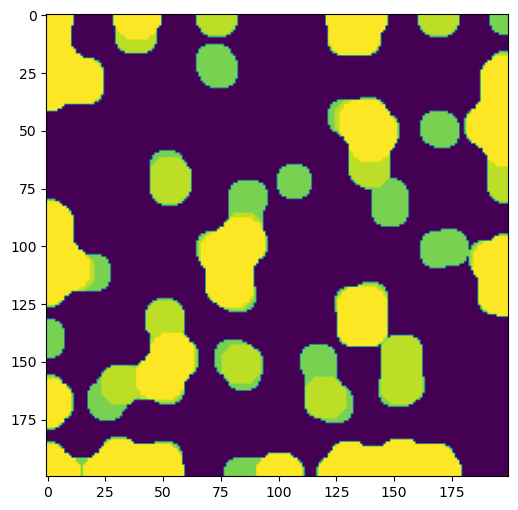

In [15]:
R = 8
temp = spim.binary_dilation(dt >= R, structure=ps.tools.ps_round(r=R, ndim=2))
lt = lt + R*temp*(lt == 0)
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.imshow(lt);

### Repeat with R=7
---

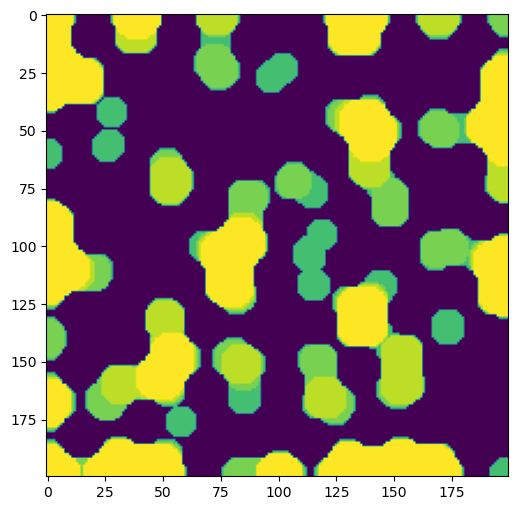

In [16]:
R = 7
temp = spim.binary_dilation(dt >= R, structure=ps.tools.ps_round(r=R, ndim=2))
lt = lt + R*temp*(lt == 0)
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.imshow(lt);

## Chord Length Distributions
---
Chords are lines drawn across the void space, spanning from one side of a pore to the other.  Their length therefore indicates the pore size.

They *can* be drawn in random directions, but the real power of chords is to detect anistropy: pores that are elgongated in one direction.

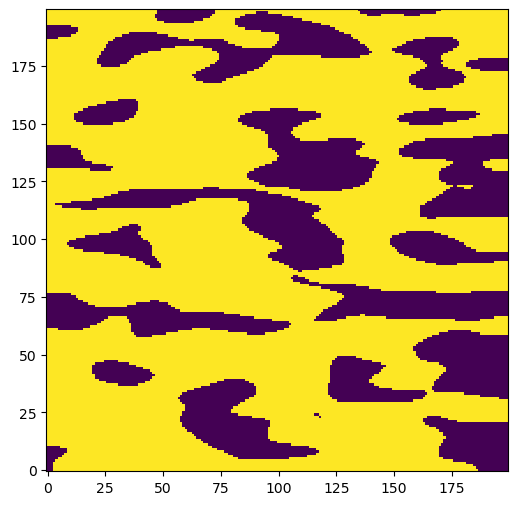

In [17]:
im = ps.generators.blobs([200, 200], blobiness=[1.5, 0.5], porosity=0.7)
fig, ax = plt.subplots(figsize=[6, 6])
ax.imshow(im, interpolation='none', origin='lower');


### Draw Chords
---
The ``filters`` module contains 2 functions for drawning chords:
- ``apply_chords`` will add chords to the image, all in the same direction
- ``apply_chords_3D`` draws chords in all three principle directions, which only works for 3D images

In [18]:
crds_x = ps.filters.apply_chords(im, axis=0)
crds_y = ps.filters.apply_chords(im, axis=1)

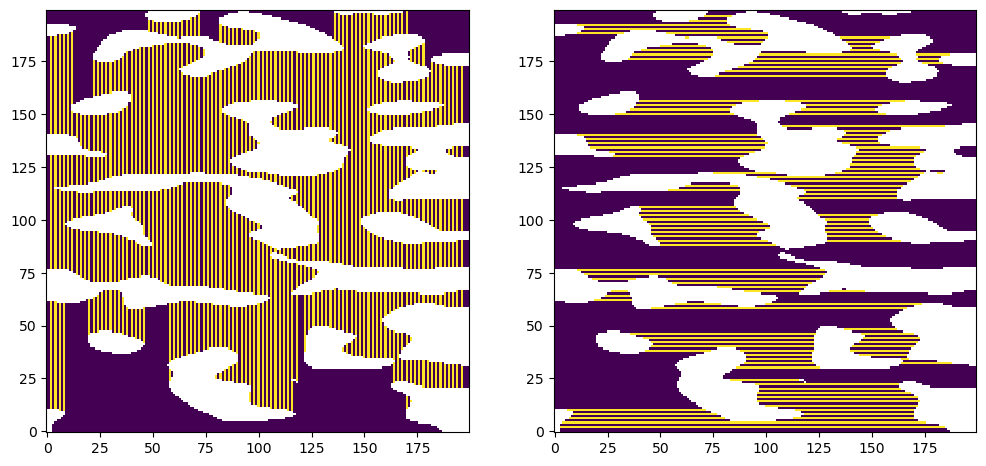

In [19]:
fig, ax = plt.subplots(1, 2, figsize=[12, 6])
ax[0].imshow(crds_x/im, origin='lower', interpolation='none')
ax[1].imshow(crds_y/im, origin='lower', interpolation='none');

> Note that chords touching the image boundary have been removed since these would be artificial shortened.

### Analyze Chord Length
---
One of the benefits of drawing chords only along the principle axes is their length is equal to the number of voxels, which is easy to count.

In [20]:
crds_x = ps.filters.region_size(crds_x)
crds_y = ps.filters.region_size(crds_y)

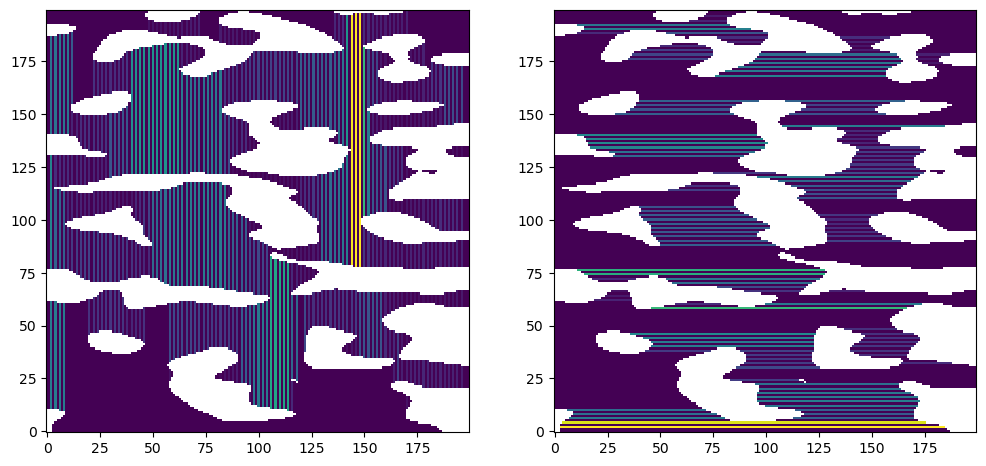

In [21]:
fig, ax = plt.subplots(1, 2, figsize=[12, 6])
ax[0].imshow(crds_x/im, origin='lower', interpolation='none')
ax[1].imshow(crds_y/im, origin='lower', interpolation='none');

### Get Chord Length Distributions
---
The ``metrics`` module contains a function for converting the chord lenghts into property statistical distributions:

In [22]:
cld_x = ps.metrics.chord_length_distribution(crds_x, bins=10)
cld_y = ps.metrics.chord_length_distribution(crds_y, bins=10)

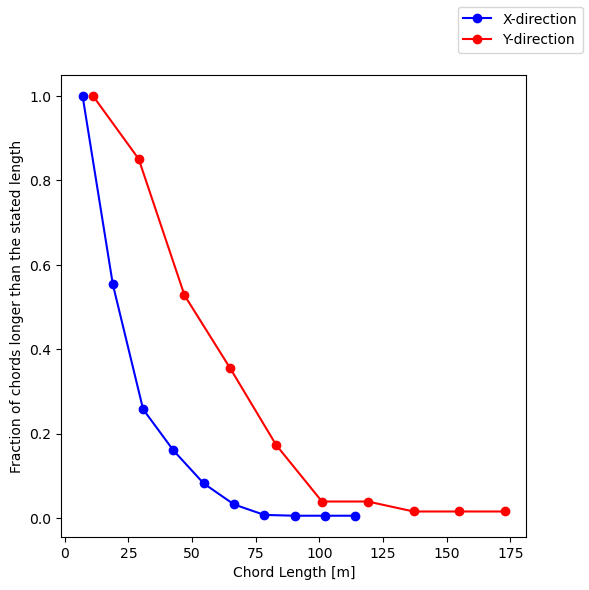

In [23]:
fig, ax = plt.subplots(figsize=[6, 6])
ax.plot(cld_x.L, cld_x.cdf, 'b-o', label='X-direction')
ax.plot(cld_y.L, cld_y.cdf, 'r-o', label='Y-direction')
ax.set_xlabel('Chord Length [m]')
ax.set_ylabel('Fraction of chords longer than the stated length')
fig.legend();

## Survey of Other Available Analysis Tools in PoreSpy
---
The *porespy.org* website has extensive documentation

- Here is a [list](https://porespy.org/_examples/filters/index.html) of functions in the ``filters`` module
- Here is a [list](https://porespy.org/_examples/metrics/index.html) of functions in the ``metrics`` module